## **1. Instalação das dependências**

In [41]:
!pip -q install pandas numpy tqdm networkx matplotlib pyvis ipywidgets

## **2. Configura ambiente e cria diretórios**

Detecta se está no `Colab` e cria as pastas:

* `DATA_DIR` (dados),
* `OUT_DIR` (saídas),
* `TMP_DIR` (saídas temporárias em /content, que somem no reset).

In [42]:
import os

IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

DATA_DIR = "/content/corpus" if IN_COLAB else "./corpus"
OUT_DIR  = "/content/outputs" if IN_COLAB else "./outputs"
TMP_DIR  = "/content/kgs_tmp" if IN_COLAB else "./tmp"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(TMP_DIR, exist_ok=True)

print("✅ Pastas prontas:")
print("DATA_DIR:", DATA_DIR)
print("OUT_DIR :", OUT_DIR)
print("TMP_DIR :", TMP_DIR)

✅ Pastas prontas:
DATA_DIR: /content/corpus
OUT_DIR : /content/outputs
TMP_DIR : /content/kgs_tmp


## **3. Verificação e upload automático do dataset**

Checa se `train.jsonl` e `validation.jsonl` já existem; se não, abre upload e copia os arquivos enviados para `DATA_DIR`.

In [43]:
import os
import shutil

TRAIN_NAME = "train.jsonl"
VAL_NAME = "validation.jsonl"

train_path_drive = os.path.join(DATA_DIR, TRAIN_NAME)
val_path_drive   = os.path.join(DATA_DIR, VAL_NAME)

def ensure_dataset_file(file_path, fname):
    if os.path.exists(file_path):
        print(f"✅ Já existe: {file_path}")
        return

    if not IN_COLAB:
        raise FileNotFoundError(
            f"Não achei {fname} em {file_path}. "
            f"Coloque o arquivo manualmente nessa pasta."
        )

    from google.colab import files
    print(f"⚠️ Não achei {fname} em {DATA_DIR}. Faça upload agora:")
    up = files.upload()

    if fname in up:
        uploaded_name = fname
    else:
        if len(up) == 1:
            uploaded_name = next(iter(up.keys()))
            print(f"ℹ️ Usando arquivo enviado '{uploaded_name}' como '{fname}'")
        else:
            raise FileNotFoundError(
                f"Você não enviou o arquivo '{fname}'. "
                f"Envie exatamente com esse nome ou envie apenas 1 arquivo por vez."
            )

    uploaded_path = os.path.join("/content", uploaded_name)
    shutil.copyfile(uploaded_path, file_path)
    print(f"✅ Copiado para: {file_path}")

ensure_dataset_file(train_path_drive, TRAIN_NAME)
ensure_dataset_file(val_path_drive, VAL_NAME)

✅ Já existe: /content/corpus/train.jsonl
✅ Já existe: /content/corpus/validation.jsonl


## **4. Carrega os JSONL (train/validation) e inspeciona o *dataset***

Lê `train.jsonl` e `validation.jsonl` em `DataFrames` e imprime:
* tamanho,
* colunas,
* distribuição da variável label.

In [44]:
import json
import pandas as pd

def load_jsonl(path: str) -> pd.DataFrame:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

train_df = load_jsonl(train_path_drive)
val_df   = load_jsonl(val_path_drive)

print("train:", train_df.shape, "| val:", val_df.shape)
print("columns:", list(train_df.columns))
print("label counts:\n", train_df["label"].value_counts())

train: (3990, 5) | val: (570, 5)
columns: ['id', 'text', 'label', 'tokens', 'labels']
label counts:
 label
1    1995
0    1995
Name: count, dtype: int64


## **5. Pré-processamento: normalização de tokens**

Normaliza *tokens* do *corpus* (`tok_norm`) removendo caracteres não alfabéticos e filtrando *tokens* curtos, criando a lista `train_docs`.

In [45]:
import re
from tqdm import tqdm

_token_re = re.compile(r"[^a-záàâãéèêíïóôõöúçñ]+", flags=re.IGNORECASE)

def norm_token(t: str) -> str:
    t = t.lower().strip()
    t = _token_re.sub("", t)
    return t

def is_valid_token(t: str) -> bool:
    return bool(t) and len(t) > 1

def normalize_doc_tokens(tokens):
    toks = [norm_token(t) for t in tokens]
    return [t for t in toks if is_valid_token(t)]

train_df["tok_norm"] = train_df["tokens"].apply(normalize_doc_tokens)
val_df["tok_norm"]   = val_df["tokens"].apply(normalize_doc_tokens)

train_docs = train_df["tok_norm"].tolist()
print("Exemplo tok_norm:", train_df["tok_norm"].iloc[0][:30])

Exemplo tok_norm: ['por', 'que', 'carteiro', 'foi', 'feira', 'porque', 'tinha', 'uma', 'carta', 'na', 'manga']


## **6. Construção dos grafos de conhecimento (3 variantes)**

Cria três grafos a partir do *train*:
* **KG-Cooc (count)**: coocorrência por janela (*window*) com peso = contagem.
* **KG-PPMI**: coocorrência por janela com peso = PPMI (associação estatística).
* **KG-PunContext**: conecta tokens marcados como *“pun”* com *tokens* do contexto em exemplos positivos, peso = contagem.

In [46]:
import math
from collections import Counter, defaultdict

def build_cooc_graph_count(docs, window=5, min_freq=5, top_k=30):
    freq = Counter()
    for d in docs:
        freq.update(d)
    vocab = {w for w, c in freq.items() if c >= min_freq}

    edges = defaultdict(int)

    for d in tqdm(docs, desc="KG-Cooc (count)"):
        d = [w for w in d if w in vocab]
        for i, w in enumerate(d):
            left  = max(0, i - window)
            right = min(len(d), i + window + 1)
            for j in range(left, right):
                if j == i:
                    continue
                u = d[j]
                if u == w:
                    continue
                a, b = (w, u) if w < u else (u, w)
                edges[(a, b)] += 1

    if top_k is not None:
        neigh = defaultdict(list)
        for (a, b), w in edges.items():
            neigh[a].append((b, w))
            neigh[b].append((a, w))

        keep = set()
        for node, lst in neigh.items():
            lst.sort(key=lambda x: x[1], reverse=True)
            for nb, _w in lst[:top_k]:
                x, y = (node, nb) if node < nb else (nb, node)
                keep.add((x, y))
        edges = {e: edges[e] for e in keep}

    return vocab, dict(edges)

def build_cooc_graph_ppmi(docs, window=5, min_freq=5, top_k=30):
    freq = Counter()
    for d in docs:
        freq.update(d)
    vocab = {w for w, c in freq.items() if c >= min_freq}

    cooc = defaultdict(int)
    word_count = Counter()
    total_pairs = 0

    for d in tqdm(docs, desc="KG-PPMI"):
        d = [w for w in d if w in vocab]
        for i, w in enumerate(d):
            word_count[w] += 1
            left  = max(0, i - window)
            right = min(len(d), i + window + 1)
            for j in range(left, right):
                if j == i:
                    continue
                u = d[j]
                if u == w:
                    continue
                a, b = (w, u) if w < u else (u, w)
                cooc[(a, b)] += 1
                total_pairs += 1

    total_words = sum(word_count.values())
    edges = {}
    for (a, b), c_ab in cooc.items():
        p_ab = c_ab / max(total_pairs, 1)
        p_a  = word_count[a] / max(total_words, 1)
        p_b  = word_count[b] / max(total_words, 1)
        pmi  = math.log((p_ab / (p_a * p_b + 1e-12)) + 1e-12)
        ppmi = max(0.0, pmi)
        if ppmi > 0:
            edges[(a, b)] = ppmi

    if top_k is not None:
        neigh = defaultdict(list)
        for (a, b), w in edges.items():
            neigh[a].append((b, w))
            neigh[b].append((a, w))

        keep = set()
        for node, lst in neigh.items():
            lst.sort(key=lambda x: x[1], reverse=True)
            for nb, _w in lst[:top_k]:
                x, y = (node, nb) if node < nb else (nb, node)
                keep.add((x, y))
        edges = {e: edges[e] for e in keep}

    return vocab, dict(edges)

def extract_pun_tokens(row):
    pun = []
    for t, lab in zip(row["tokens"], row["labels"]):
        if lab == 1:
            nt = norm_token(t)
            if is_valid_token(nt):
                pun.append(nt)
    return pun

train_df["pun_tokens"] = train_df.apply(extract_pun_tokens, axis=1)

def build_pun_context_graph(df, min_freq=3, top_k=40):
    pos = df[df["label"] == 1].copy()

    freq = Counter()
    for toks in pos["tok_norm"]:
        freq.update(toks)
    vocab = {w for w, c in freq.items() if c >= min_freq}

    edges = defaultdict(int)
    for _, row in tqdm(pos.iterrows(), total=len(pos), desc="KG-PunContext"):
        pun = [w for w in row["pun_tokens"] if w in vocab]
        ctx = [w for w in row["tok_norm"]   if w in vocab]

        for p in pun:
            for c in ctx:
                if p == c:
                    continue
                a, b = (p, c) if p < c else (c, p)
                edges[(a, b)] += 1

    if top_k is not None:
        neigh = defaultdict(list)
        for (a, b), w in edges.items():
            neigh[a].append((b, w))
            neigh[b].append((a, w))

        keep = set()
        for node, lst in neigh.items():
            lst.sort(key=lambda x: x[1], reverse=True)
            for nb, _w in lst[:top_k]:
                x, y = (node, nb) if node < nb else (nb, node)
                keep.add((x, y))
        edges = {e: edges[e] for e in keep}

    return vocab, dict(edges)

VOC_cooc, edges_cooc = build_cooc_graph_count(train_docs, window=5, min_freq=5, top_k=30)
VOC_ppmi, edges_ppmi = build_cooc_graph_ppmi(train_docs, window=5, min_freq=5, top_k=30)
VOC_pun,  edges_pun  = build_pun_context_graph(train_df,  min_freq=3, top_k=40)

print("✅ Edges geradas:")
print("Cooc:", len(edges_cooc), "| PPMI:", len(edges_ppmi), "| PunContext:", len(edges_pun))

KG-PunContext: 100%|██████████| 1995/1995 [00:00<00:00, 14902.61it/s]

✅ Edges geradas:
Cooc: 22730 | PPMI: 18363 | PunContext: 5071


## **7. Converter para *NetworkX* e salvar**

Transforma os dicionários de arestas em grafos *networkx*, e salva:
* `.gpickle` (grafo completo),
* `.csv` (arestas)

tanto no `OUT_DIR` quanto no `TMP_DIR` (*runtime*).

In [47]:
import networkx as nx
import pickle

def edges_to_nx_graph(edges_dict):
    G = nx.Graph()
    for (a, b), w in edges_dict.items():
        G.add_edge(a, b, weight=float(w))
    return G

G_cooc = edges_to_nx_graph(edges_cooc)
G_ppmi = edges_to_nx_graph(edges_ppmi)
G_pun  = edges_to_nx_graph(edges_pun)

def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def save_edges_csv(edges_dict, path):
    import pandas as pd
    rows = [(a, b, float(w)) for (a, b), w in edges_dict.items()]
    pd.DataFrame(rows, columns=["src", "dst", "weight"]).to_csv(path, index=False)

names = {
    "cooc": ("KG_cooc.gpickle", "KG_cooc_edges.csv"),
    "ppmi": ("KG_ppmi.gpickle", "KG_ppmi_edges.csv"),
    "pun":  ("KG_puncontext.gpickle", "KG_puncontext_edges.csv"),
}

for key, (gp_name, csv_name) in names.items():
    G = {"cooc": G_cooc, "ppmi": G_ppmi, "pun": G_pun}[key]
    E = {"cooc": edges_cooc, "ppmi": edges_ppmi, "pun": edges_pun}[key]

    save_pickle(G, os.path.join(OUT_DIR, gp_name))
    save_edges_csv(E, os.path.join(OUT_DIR, csv_name))

print("✅ Salvo!")
print("✅ Outputs:", OUT_DIR)

print("\n📌 Stats:")
print("cooc:", G_cooc.number_of_nodes(), "nodes,", G_cooc.number_of_edges(), "edges")
print("ppmi:", G_ppmi.number_of_nodes(), "nodes,", G_ppmi.number_of_edges(), "edges")
print("pun :", G_pun.number_of_nodes(),  "nodes,", G_pun.number_of_edges(),  "edges")

✅ Salvo!
✅ Outputs: /content/outputs

📌 Stats:
cooc: 1153 nodes, 22730 edges
ppmi: 1153 nodes, 18363 edges
pun : 921 nodes, 5071 edges


## **8. Relatório dos grafos (estatísticas + top nós)**

Gera métricas (nós, arestas, densidade, componentes…) e uma tabela estilizada com os nós mais “importantes” por:
* `degree` (número de vizinhos),
* `weighted_degree` (soma dos pesos das arestas do nó).

In [48]:
import pandas as pd
import numpy as np

def graph_report(G: nx.Graph, name="G", top_n=20):
    deg  = dict(G.degree())
    wdeg = dict(G.degree(weight="weight"))

    df_nodes = pd.DataFrame({
        "node": list(G.nodes()),
        "degree": [deg[n] for n in G.nodes()],
        "weighted_degree": [wdeg[n] for n in G.nodes()],
    }).sort_values(["weighted_degree", "degree"], ascending=False)

    stats = {
        "name": name,
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "density": nx.density(G),
        "components": nx.number_connected_components(G),
        "largest_component_nodes": len(max(nx.connected_components(G), key=len)) if G.number_of_nodes() else 0,
        "avg_degree": float(np.mean(list(deg.values()))) if deg else 0.0,
        "avg_weighted_degree": float(np.mean(list(wdeg.values()))) if wdeg else 0.0,
    }
    return pd.DataFrame([stats]), df_nodes.head(top_n)

def style_top(df):
    return (df.style
            .format({"weighted_degree": "{:.3f}"})
            .background_gradient(subset=["weighted_degree"], cmap="Blues")
            .background_gradient(subset=["degree"], cmap="Greens"))

for title, G in [("KG-Cooc", G_cooc), ("KG-PPMI", G_ppmi), ("KG-PunContext", G_pun)]:
    stats, topn = graph_report(G, title, top_n=25)
    display(stats)
    display(style_top(topn))

,name,nodes,edges,density,components,largest_component_nodes,avg_degree,avg_weighted_degree
0,KG-Cooc,1153,22730,0.034225,1,1153,39.42758,296.582827


,node,degree,weighted_degree
14,que,1046,29254.000
108,qual,909,18612.000
6,de,922,16772.000
27,um,653,9604.000
70,porque,573,8910.000
18,do,634,8260.000
146,não,484,6168.000
28,por,467,6078.000
43,se,438,5442.000
61,em,467,5376.000


,name,nodes,edges,density,components,largest_component_nodes,avg_degree,avg_weighted_degree
0,KG-PPMI,1153,18363,0.02765,1,1153,31.852559,101.622727


,node,degree,weighted_degree
107,de,532,606.664
62,do,391,573.904
324,na,264,535.988
57,um,364,517.993
315,no,261,511.372
201,da,260,507.920
17,uma,277,505.561
89,porque,325,478.655
384,não,276,478.102
7,em,272,477.816


,name,nodes,edges,density,components,largest_component_nodes,avg_degree,avg_weighted_degree
0,KG-PunContext,921,5071,0.01197,1,921,11.011944,15.246471


,node,degree,weighted_degree
42,que,318,720.000
10,de,283,610.000
91,qual,244,420.000
85,um,154,283.000
130,em,136,238.000
19,do,138,237.000
27,por,122,191.000
114,com,125,188.000
44,porque,113,184.000
72,na,100,175.000


## **9. Visualização estática (subgrafo Top-N)**

Seleciona um subgrafo com os Top-N nós (por grau ponderado) e desenha com *layout* `spring_layout`.

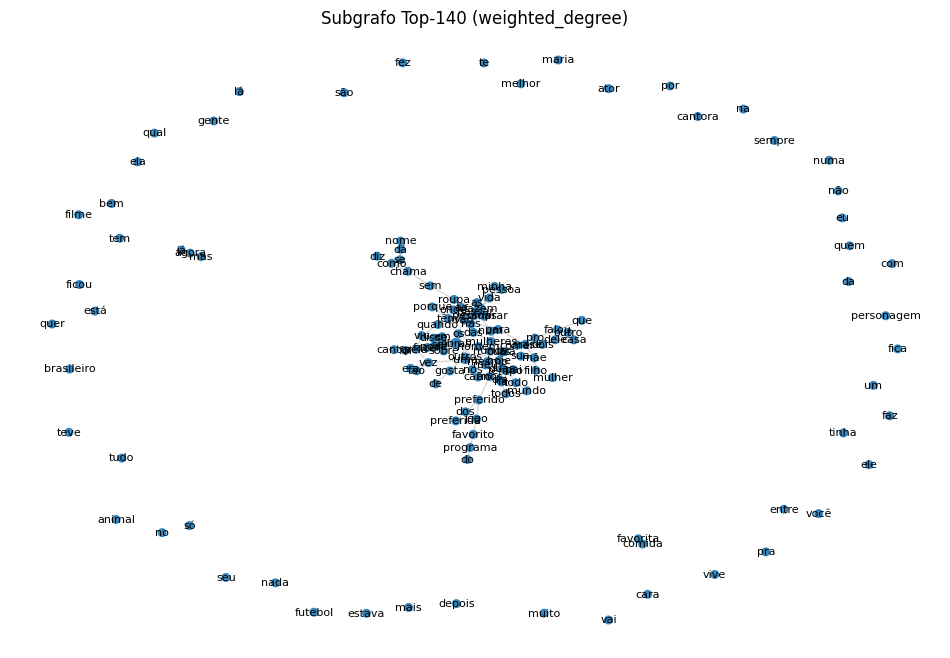

In [49]:
import matplotlib.pyplot as plt

def subgraph_top_nodes(G, n=150, by="weighted_degree"):
    scores = dict(G.degree(weight="weight")) if by == "weighted_degree" else dict(G.degree())
    top_nodes = sorted(scores, key=scores.get, reverse=True)[:n]
    return G.subgraph(top_nodes).copy()

def draw_static(G, title="", seed=42):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=seed)

    wdeg = dict(G.degree(weight="weight"))
    max_w = max(wdeg.values()) if wdeg else 1.0
    sizes = [max(30, min(900, 50*(wdeg.get(n, 1.0)/max_w))) for n in G.nodes()]

    nx.draw_networkx_edges(G, pos, alpha=0.15, width=1.0)
    nx.draw_networkx_nodes(G, pos, node_size=sizes, alpha=0.85)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(title)
    plt.axis("off")
    plt.show()

G_show = G_ppmi  # G_cooc / G_ppmi / G_pun
H = subgraph_top_nodes(G_show, n=140, by="weighted_degree")
draw_static(H, title="Subgrafo Top-140 (weighted_degree)")

## **10. Visualização interativa (PyVis) e exportação para HTML**

Cria um grafo interativo com *zoom*/arraste/*hover*, salva em `.html` e exibe no *notebook*.

In [50]:
from pyvis.network import Network

def show_pyvis(G, html_path, height="700px", width="100%", bgcolor="#111111", font_color="white"):
    net = Network(height=height, width=width, bgcolor=bgcolor, font_color=font_color,
                  notebook=True, cdn_resources="in_line")
    net.barnes_hut()

    wdeg = dict(G.degree(weight="weight"))
    max_w = max(wdeg.values()) if wdeg else 1.0

    for n in G.nodes():
        val = wdeg.get(n, 0.0)
        size = 10 + 35*(val/max_w)
        net.add_node(n, label=n, title=f"{n}<br>weighted_degree={val:.3f}", value=size)

    for u, v, data in G.edges(data=True):
        w = float(data.get("weight", 1.0))
        net.add_edge(u, v, value=w, title=f"weight={w:.3f}")

    net.set_options("""
    var options = {
      "nodes": { "borderWidth": 0, "shadow": true },
      "edges": { "smooth": { "type": "dynamic" } },
      "interaction": { "hover": true, "tooltipDelay": 120, "hideEdgesOnDrag": true },
      "physics": { "enabled": true, "stabilization": { "iterations": 200 } }
    }
    """)

    net.write_html(html_path)
    return html_path

G_show = G_pun  # G_cooc / G_ppmi / G_pun
H = subgraph_top_nodes(G_show, n=220, by="weighted_degree")

html_out = os.path.join(OUT_DIR, "graph_interactive.html")
show_pyvis(H, html_out)
print("✅ HTML salvo:", html_out)

if IN_COLAB:
    from IPython.display import HTML, display
    display(HTML(filename=html_out))

✅ HTML salvo: /content/outputs/graph_interactive.html


## **11. Ego-graph (rede local de uma palavra)**

Dado um *word*, cria um subgrafo centrado nela (seus vizinhos mais relevantes) e exporta/mostra em HTML.

In [51]:
def ego_subgraph(G, center, radius=1, top_k_neighbors=60):
    if center not in G:
        raise ValueError(f"Nó '{center}' não está no grafo.")
    E = nx.ego_graph(G, center, radius=radius)

    if top_k_neighbors is not None and E.number_of_nodes() > top_k_neighbors + 1:
        nbrs = [(nbr, G[center][nbr].get("weight", 1.0)) for nbr in G.neighbors(center)]
        nbrs.sort(key=lambda x: x[1], reverse=True)
        keep = {center} | {n for n,_ in nbrs[:top_k_neighbors]}
        E = E.subgraph(keep).copy()
    return E

G_show = G_ppmi
word = next(iter(G_show.nodes()))
E = ego_subgraph(G_show, word, radius=1, top_k_neighbors=50)

html_ego = os.path.join(OUT_DIR, f"ego_{word}.html")
show_pyvis(E, html_ego)
print("✅ Ego-graph salvo:", html_ego)

if IN_COLAB:
    from IPython.display import HTML, display
    display(HTML(filename=html_ego))

✅ Ego-graph salvo: /content/outputs/ego_filósofo.html
